In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd 

In [2]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
medium_articles = pd.read_csv("articles.csv")
medium_articles.head()

,author,claps,reading_time,link,title,text
0,Justin Lee,8.3K,11,https://medium.com/swlh/chatbots-were-the-next...,Chatbots were the next big thing: what happene...,"Oh, how the headlines blared:\nChatbots were T..."
1,Conor Dewey,1.4K,7,https://towardsdatascience.com/python-for-data...,Python for Data Science: 8 Concepts You May Ha...,If you’ve ever found yourself looking up the s...
2,William Koehrsen,2.8K,11,https://towardsdatascience.com/automated-featu...,Automated Feature Engineering in Python – Towa...,Machine learning is increasingly moving from h...
3,Gant Laborde,1.3K,7,https://medium.freecodecamp.org/machine-learni...,Machine Learning: how to go from Zero to Hero ...,If your understanding of A.I. and Machine Lear...
4,Emmanuel Ameisen,935,11,https://blog.insightdatascience.com/reinforcem...,Reinforcement Learning from scratch – Insight ...,Want to learn about applied Artificial Intelli...


In [4]:
article_text = medium_articles.text
# visualise first article print few words from it
print("First 1000 words in first article are : \n",article_text[0][:1000])
# article_text

First 1000 words in first article are : 
 Oh, how the headlines blared:
Chatbots were The Next Big Thing.
Our hopes were sky high. Bright-eyed and bushy-tailed, the industry was ripe for a new era of innovation: it was time to start socializing with machines.
And why wouldn’t they be? All the road signs pointed towards insane success.
At the Mobile World Congress 2017, chatbots were the main headliners. The conference organizers cited an ‘overwhelming acceptance at the event of the inevitable shift of focus for brands and corporates to chatbots’.
In fact, the only significant question around chatbots was who would monopolize the field, not whether chatbots would take off in the first place:
One year on, we have an answer to that question.
No.
Because there isn’t even an ecosystem for a platform to dominate.
Chatbots weren’t the first technological development to be talked up in grandiose terms and then slump spectacularly.
The age-old hype cycle unfolded in familiar fashion...
Expectat

In [5]:
#total number of author
print(f"Total Number of unique authors : {len(medium_articles.author.unique())}")
# print("Totoal Number Of Author :\n " , medium_articles.iloc["author"].value_counts())

Total Number of unique authors : 182


In [6]:
#counting the articles of different authors
article_counts = dict()
for author in medium_articles.author:
    article_count = len(medium_articles[medium_articles["author"]==author])
    article_counts[author] = article_count

#sorting the article_counts on the basis of article count
article_counts = dict(sorted(article_counts.items(), key=lambda x: x[1], reverse=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Adam Geitgey'),
  Text(1, 0, 'Arthur Juliani'),
  Text(2, 0, 'Slav Ivanov'),
  Text(3, 0, 'Milo Spencer-Harper'),
  Text(4, 0, 'Dhruv Parthasarathy'),
  Text(5, 0, 'Netflix Technology Blog'),
  Text(6, 0, 'Andrej Karpathy'),
  Text(7, 0, 'Stefan Kojouharov'),
  Text(8, 0, 'Sarthak Jain'),
  Text(9, 0, 'Justin Lee')])

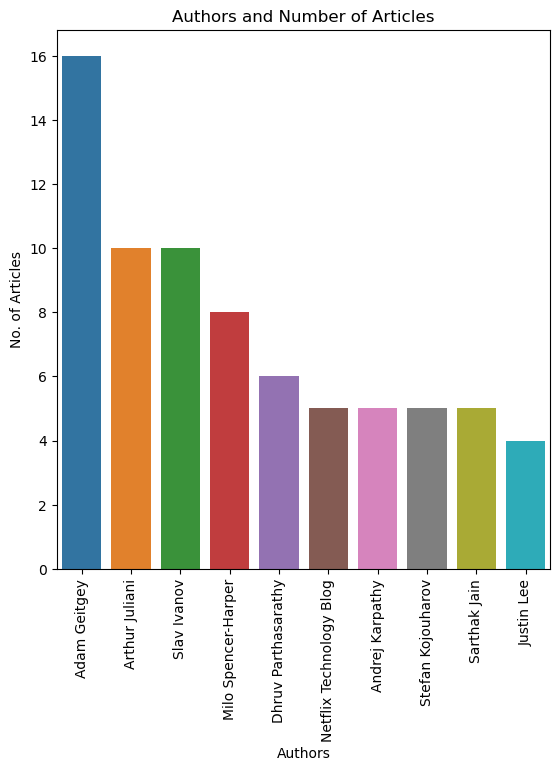

In [7]:
#plot histogram of top 10 authors and their article counts
plt.figure(figsize=(14,7))
plt.subplot(1, 2, 1)
sns.barplot(x = list(article_counts.keys())[:10],y=list(article_counts.values())[:10])
plt.title("Authors and Number of Articles")
plt.xlabel("Authors")
plt.ylabel("No. of Articles")
plt.xticks(rotation = 90)

In [8]:
#counting the total number of claps for each author
def convert_to_num(clap_count):
    if "K" in clap_count:
        if "." in clap_count:
            clap_count = re.sub("\.","",clap_count[:-1])+"00"
        else:
            clap_count = clap_count[:-1]+"000"
    return(int(clap_count))

medium_articles.claps = medium_articles.claps.apply(convert_to_num)

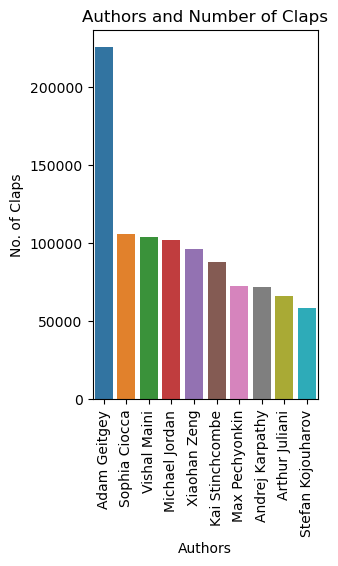

In [9]:
#couting total number of claps for each author
clap_counts = dict()
for author in medium_articles.author:
    clap_count = medium_articles[medium_articles["author"]==author]["claps"]
    clap_counts[author] = sum(clap_count)

#sort clap_counts on the basis of counting of claps
clap_counts = dict(sorted(clap_counts.items(), key=lambda x: x[1], reverse=True))

#plot histogram of top 10 authors and their article counts
plt.subplot(1, 2, 2)
sns.barplot(x = list(clap_counts.keys())[:10],y=list(clap_counts.values())[:10])
plt.title("Authors and Number of Claps")
plt.xlabel("Authors")
plt.ylabel("No. of Claps")
plt.xticks(rotation = 90) 
plt.show()

# Preprocessing The Data

In [10]:
pip install typing-extensions --upgrade

Note: you may need to restart the kernel to use updated packages.


In [11]:
import spacy
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)


lemmatized_texts = lemmatization(medium_articles.text)

In [12]:
print (lemmatized_texts[0][0:90])

headline blare next big thing hope sky high bright eyed bushy tail industry ripe new era i


In [13]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words = gen_words(lemmatized_texts)

print (data_words[0][0:20])

['headline', 'blare', 'next', 'big', 'thing', 'hope', 'sky', 'high', 'bright', 'eyed', 'bushy', 'tail', 'industry', 'ripe', 'new', 'era', 'innovation', 'time', 'start', 'socialize']


In [19]:
id2word = corpora.Dictionary(data_words)

corpus = []
for text in data_words:
    new = id2word.doc2bow(text)
    corpus.append(new)

print (corpus[0][0:20])

word = id2word[[0][:1][0]]
print (word)
corpus

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)]
able


[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 2),
  (7, 2),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 2),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 12),
  (25, 1),
  (26, 3),
  (27, 2),
  (28, 2),
  (29, 1),
  (30, 1),
  (31, 2),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 2),
  (37, 1),
  (38, 1),
  (39, 2),
  (40, 3),
  (41, 1),
  (42, 2),
  (43, 1),
  (44, 1),
  (45, 2),
  (46, 2),
  (47, 1),
  (48, 1),
  (49, 2),
  (50, 2),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 30),
  (55, 1),
  (56, 1),
  (57, 2),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 7),
  (64, 2),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 2),
  (79, 1),
  (80, 1),
  (81, 11),
  (82, 2),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 2),
  (87, 1),
  (88, 1),
  (89, 1),
  (90, 2),
  (91,

In [15]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

In [16]:
pip install pyLDAvis

Note: you may need to restart the kernel to use updated packages.


In [17]:
# Vissualizing the Data : 
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.055464  0.131176       1        1  34.312321
4     -0.094021 -0.084518       2        1  27.420936
2     -0.167551 -0.003177       3        1  25.873588
0      0.118668 -0.171209       4        1   6.958035
3      0.198368  0.127728       5        1   5.435119, topic_info=         Term         Freq        Total Category  logprob  loglift
1256    image  1383.000000  1383.000000  Default  30.0000  30.0000
312     learn  1470.000000  1470.000000  Default  29.0000  29.0000
666    course   494.000000   494.000000  Default  28.0000  28.0000
951   network  2720.000000  2720.000000  Default  27.0000  27.0000
952    neural  1608.000000  1608.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
947     model    55.712947  1436.195760   Topic5  -5.6901  -0.3373
340      make    51.940762  1545.570526   Topic5  -5.7602  -0.4808
501       see    48.734156  1164.549604   Topic5  -5.8240  -0.2614
605      want    47.365726   747.528291   Topic5  -5.8524   0.1534
400     other    46.803736  1188.621499   Topic5  -5.8644  -0.3223

[418 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1762      1  0.970510  academic
2011      2  0.131165  accuracy
2011      3  0.863505  accuracy
842       1  0.056341    action
842       3  0.887933    action
...     ...       ...       ...
620       1  0.610273      year
620       2  0.102332      year
620       3  0.219550      year
620       4  0.024188      year
620       5  0.042794      year

[864 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 3, 1, 4])